In [1]:
# 


In [2]:
import geopandas as gpd
import json
import matplotlib
import matplotlib.cm as cm
import matplotlib.colors as colors
from datetime import timedelta
import matplotlib.pyplot as plt
import networkx as nx
from shapely.geometry import Point
from shapely.geometry import LineString
from shapely.geometry import MultiLineString
import numpy as np
import numpy as npm
import osmnx as ox
import math
import pandas as pd
from shapely.ops import snap
from tqdm import tqdm
import re

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
CRS_LATLON = 'EPSG:4326'
DATA_DIR = '../../data'
EXPORTS_DIR = f'{DATA_DIR}/exports'

In [4]:
def peek(df):
    print(len(df))
    display(df.iloc[0:3])

In [5]:
trip_stop_sequence_dict = {}
with open(f'{EXPORTS_DIR}/json/manhattan/trip_stop_sequence_dict.json', 'r') as fp:
    trip_stop_sequence_dict = json.load(fp)

In [6]:
trip_manifest = {}
with open(f'{EXPORTS_DIR}/json/manhattan/trip_manifest.json', 'r') as fp:
    trip_manifest = json.load(fp)

In [7]:
timetable_df = pd.read_csv(f'{EXPORTS_DIR}/csv/manhattan/timetable.csv')
peek(timetable_df)

505068


,trip_id,arrival_time,departure_time,stop_id,stop_sequence,pickup_type,drop_off_type,trip_headsign,shape_id
0,OF_C1-Weekday-033500_M1_101,05:35:00,05:35:00,400001,1,0,0,HARLEM 147 ST via MADISON AV,M010006
1,OF_C1-Weekday-033500_M1_101,05:35:36,05:35:36,400002,2,0,0,HARLEM 147 ST via MADISON AV,M010006
2,OF_C1-Weekday-033500_M1_101,05:36:14,05:36:14,400003,3,0,0,HARLEM 147 ST via MADISON AV,M010006


In [8]:
stops_nodes_df = pd.read_csv(f'{EXPORTS_DIR}/csv/manhattan/stops_nodes.csv')
stops_nodes_df = stops_nodes_df.set_index('stop_id')
peek(stops_nodes_df)

1780


,stop_name,stop_lat,stop_lon,M1,M10,M100,M101,M102,M103,M104,...,M5,M50,M55,M57,M66,M7,M72,M8,M9,M96
stop_id,,,,,,,,,,,,,,,,,,,,,
400001,4 AV/E 10 ST,40.731342,-73.990292,POINT (-73.99037 40.73135299999986),NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
400002,4 AV/E 12 ST,40.732608,-73.989958,POINT (-73.990059 40.73262099999981),NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
400003,4 AV/E 13 ST,40.733936,-73.989720,POINT (-73.98985 40.73393799999985),NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
route_ids = list(stops_nodes_df.columns[3:])

In [10]:
from shapely import wkt

route_gdfs = []

for route_id in route_ids:
    route_df = stops_nodes_df[~stops_nodes_df[route_id].isna()]
    route_df[route_id] = route_df[route_id].apply(wkt.loads)
    route_df = route_df[[route_id]]
    route_gdf = gpd.GeoDataFrame(route_df, geometry=route_df[route_id], crs=CRS_LATLON)
    route_gdfs.append(route_gdf)


In [11]:
def get_distance(row):
    if row['last_geometry'] is None:
        return None
    # Approx degrees to meters
    return row['geometry'].distance(row['last_geometry']) * (0.11 / 0.000001)

In [12]:
def get_point_df(trip_key):
    sequence_key = trip_key[-1]
    sequence = trip_stop_sequence_dict[trip_key][sequence_key]
    
    sequence_df = pd.DataFrame({'stop_id': sequence})
    sequence_df = sequence_df.set_index('stop_id')

    route_index = route_ids.index(route_id)
    route_gdf = route_gdfs[route_index]

    sequence_df = sequence_df.merge(route_gdf, left_index=True, right_index=True, how='left')
    
    sequence_gdf = gpd.GeoDataFrame(sequence_df, crs=CRS_LATLON)
    sequence_gdf = sequence_gdf[['geometry']]
    
    return sequence_gdf

In [13]:
def get_distance_df(trip_key):
    sequence_key = trip_key[-1]
    sequence = trip_stop_sequence_dict[trip_key][sequence_key]
    
    sequence_df = pd.DataFrame({'stop_id': sequence})
    sequence_df = sequence_df.set_index('stop_id')

    route_index = route_ids.index(route_id)
    route_gdf = route_gdfs[route_index]

    sequence_df = sequence_df.merge(route_gdf, left_index=True, right_index=True, how='left')
    sequence_df = sequence_df.drop(columns=[route_id])
    
    sequence_gdf = gpd.GeoDataFrame(sequence_df, crs=CRS_LATLON)
    sequence_gdf['last_geometry'] = sequence_gdf['geometry'].shift()
    sequence_gdf['distance'] = sequence_gdf.apply(lambda x: get_distance(x), axis=1)
    sequence_gdf
    
    return sequence_gdf

In [14]:
trip_manifest = {}
with open(f'{EXPORTS_DIR}/json/manhattan/trip_manifest.json', 'r') as fp:
    trip_manifest = json.load(fp)

In [15]:
def get_duration(row):
    try:
        start_time = row['last_time']
        end_time = row['time']

        if int(start_time[0:2]) > 23 or int(end_time[0:2]) > 23:
            start_time = f'{int(start_time[0:2]) - 12}{start_time[2:]}'
            end_time = f'{int(end_time[0:2]) - 12}{end_time[2:]}'
    
        return pd.Timedelta(pd.to_datetime(end_time, format='%H:%M:%S') - pd.to_datetime(start_time, format='%H:%M:%S')).seconds
    except:
        return None

In [16]:
def get_times_df(trip_id):
    timetable_mi_df = timetable_df[timetable_df['trip_id'].str.contains(trip_id)]
    timetable_mi_df = timetable_mi_df[timetable_mi_df['trip_id'].str.contains(f'_{route_id}_')]
    timetable_mi_df = timetable_mi_df.set_index(['trip_id', 'stop_id'])
    timetable_mi_df = timetable_mi_df.rename(columns={'arrival_time': 'time'})
    
    times_df = timetable_mi_df.loc[trip_id]
    times_df['last_time'] = times_df['time'].shift()
    times_df['duration'] = times_df.apply(lambda x: get_duration(x), axis=1)
    times_df = times_df
    return times_df

In [17]:
def get_speed_df(trip_id, point_df, times_df):
    speed_df = times_df.merge(point_df, left_index=True, right_index=True, how='left')
    speed_df = speed_df[['time', 'stop_sequence', 'geometry']]
    speed_df = speed_df[speed_df['geometry'].notnull()]
    speed_df = speed_df.sort_values(by=['stop_sequence'])
    speed_df['last_time'] = speed_df['time'].shift()
    speed_df['last_geometry'] = speed_df['geometry'].shift()
    speed_df['distance'] = speed_df.apply(lambda x: get_distance(x), axis=1)
    speed_df['duration'] = speed_df.apply(lambda x: get_duration(x), axis=1)
    speed_df['speed'] = speed_df['distance'] / speed_df['duration']
    speed_df = speed_df.drop(columns=['time', 'stop_sequence', 'last_time', 'distance', 'duration'])
    speed_df = speed_df.dropna()
    speed_df = speed_df.rename(columns={'last_geometry': 'start', 'geometry': 'end'})
    return speed_df

In [18]:
def get_avg_speed_df(trip_key):
    point_df = get_point_df(trip_key)
    speed_dfs = []
    errors = 0
    
    trip_ids = get_trip_ids(trip_key)

    for trip_id in trip_ids:
        times_df = get_times_df(trip_id)
        speed_df = get_speed_df(trip_id, point_df, times_df)
        
        speed_df['start'] = speed_df['start'].apply(lambda x: x.wkt)
        speed_df['end'] = speed_df['end'].apply(lambda x: x.wkt)
        speed_df = speed_df.reset_index()
        speed_df = speed_df.drop(columns=['stop_id'])
        speed_df = speed_df.set_index(['start', 'end'])
        speed_dfs.append(speed_df)

    all_speed_dfs = speed_dfs[0]
    all_speed_dfs = all_speed_dfs.rename(columns={'speed': 'speed_0'})
    for i, speed_df in enumerate(speed_dfs[1:]):
        all_speed_dfs = all_speed_dfs.merge(speed_df, left_index=True, right_index=True, how='outer')
        all_speed_dfs = all_speed_dfs.rename(columns={'speed': f'speed_{i+1}'})

    avg_speed_df = pd.DataFrame(all_speed_dfs.mean(axis=1))
    return avg_speed_df

In [19]:
route_mgs = []

for route_id in route_ids:
    route_mg = nx.read_shp(f'{EXPORTS_DIR}/shp/manhattan/routes/{route_id}.shp', simplify=False)
    route_mg.graph['crs'] = CRS_LATLON
    route_mgs.append(route_mg)

In [20]:
def graph_to_node_gdf(G):
    """Converts the given graph to a GeoDataFrame of its nodes."""
    nodes, data = zip(*G.nodes(data=True))
    geom = [Point(node[0], node[1]) for node in nodes]
    nodes_gdf = gpd.GeoDataFrame(data,
                                 index=list(nodes),
                                 crs=CRS_LATLON,
                                 geometry=geom)
    return nodes_gdf

In [21]:
def graph_to_edge_gdf(G):
    """Converts the given graph to a GeoDataFrame of its edges."""
    u, v, data = zip(*G.edges(data=True))
    edges = list(zip(u, v))
    attrs = nx.get_edge_attributes(G, 'speed')
    geom = [
        LineString((Point(edge[0][0],
                          edge[0][1]), Point(edge[1][0], edge[1][1])))
        for edge in edges
    ]
    edge_index = [(edge[0] + edge[1]) for edge in edges]
    edges_gdf = gpd.GeoDataFrame(data,
                                 index=edge_index,
                                 crs=CRS_LATLON,
                                 geometry=list(geom))
    edges_gdf['length'] = edges_gdf.geometry.length
    edges_gdf = edges_gdf.drop(columns={
        'route_shor',
        'route_long',
        'color',
        'ShpName',
        'Wkb',
        'Wkt',
        'Json',
    })
    return edges_gdf

In [22]:
def get_node(mg, point):
    threshold = 0.00001
    for node in route_mg.nodes():
        if abs(node[0] - point[0]) < threshold and abs(node[1] - point[1]) < threshold:
            return node
    return None

In [23]:
def get_avg_speed_attr_dict(avg_speed_df, route_mg):
    attr_dict = {}
    for row in avg_speed_df.iterrows():
        index = row[0]
        start, end = (wkt.loads(f) for f in index)
        avg_speed = row[1][0]

        start_node = get_node(route_mg, (start.x, start.y))
        end_node = get_node(route_mg, (end.x, end.y))

        path = nx.shortest_path(route_mg, start_node, end_node)

        for i in range(len(path) - 1):
            edge = (path[i], path[i+1])
            if edge not in attr_dict:
                attr_dict[edge] = {'speeds': []}
            attr_dict[edge]['speeds'].append(avg_speed)
        
    return attr_dict

In [24]:
def get_trip_ids(trip_key):
    route_id = trip_key.split(',')[0]
    trip_id = trip_key.split(',')[1]
    sequence_id = trip_key.split(',')[2]
    trip_keys = list(trip_manifest[trip_key].keys())
    trip_keys = [f for f in trip_keys if re.match(f'{trip_id}.*', f)]
    trip_keys = [f for f in trip_keys if re.match(f'.*_{route_id}_', f)]
    return trip_keys

In [25]:
trip_keys = list(trip_stop_sequence_dict.keys())[0:20]

avg_speed_dfs = []
avg_speed_attr_dicts = []
errors = 0

for trip_key in tqdm(trip_keys):
    try:
        route_id = trip_key.split(',')[0]
        trip_id = trip_key.split(',')[1]
        route_mg = route_mgs[route_ids.index(route_id)]

        avg_speed_df = get_avg_speed_df(trip_key)
        avg_speed_attr_dict = get_avg_speed_attr_dict(avg_speed_df, route_mg)

        avg_speed_dfs.append(avg_speed_df)
        avg_speed_attr_dicts.append(avg_speed_attr_dict)
    except:
        errors += 1
print(f'{len(trip_keys) - errors}/{len(trip_keys)}')

100%|██████████| 20/20 [02:22<00:00,  7.14s/it]

10/20


In [32]:
avg_speed_attr_dict = {}
for attr_dict in avg_speed_attr_dicts:
    for key, value in attr_dict.items():
        if key not in avg_speed_attr_dict:
            avg_speed_attr_dict[key] = {'speeds': []}
        avg_speed_attr_dict[key]['speeds'] += value['speeds']
        
for key, value in avg_speed_attr_dict.items():
    avg_speed_attr_dict[key] = {'speed': np.mean(value['speeds'])}

In [33]:
all_routes_mg = route_mgs[0]

for i, route_mg in enumerate(route_mgs[1:]):
    all_routes_mg = nx.compose(all_routes_mg, route_mg)

In [34]:
nx.set_edge_attributes(all_routes_mg, avg_speed_attr_dict)

In [35]:
all_nodes_gdf = graph_to_node_gdf(all_routes_mg)
all_edges_gdf = graph_to_edge_gdf(all_routes_mg)

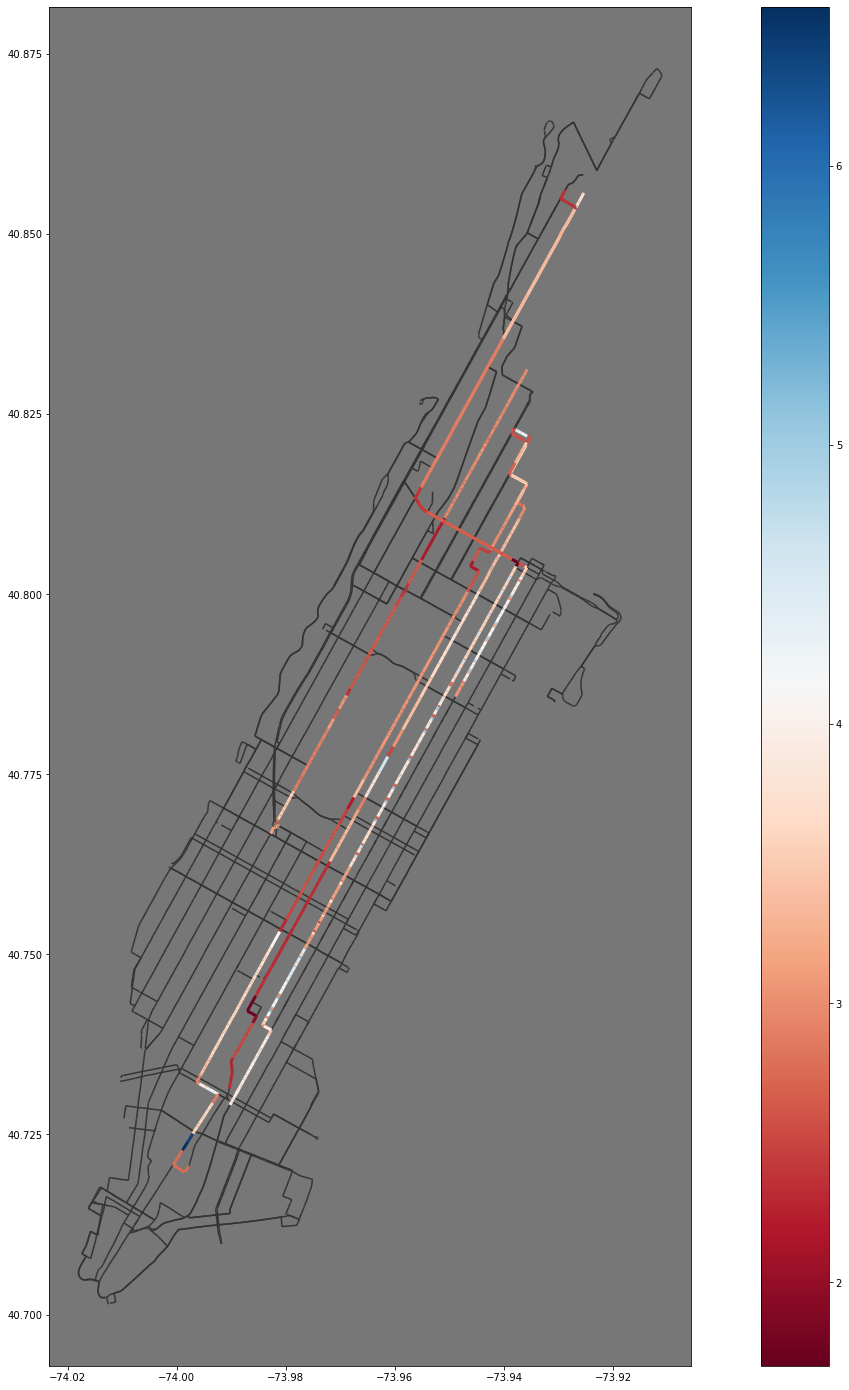

In [38]:
fig, ax = plt.subplots(figsize=(25, 25))
all_edges_gdf.plot(ax=ax, color='#333', zorder=1)
all_edges_gdf.plot(ax=ax, column='speed', cmap='RdBu', zorder=2, linewidth=3, legend=True)
ax.set_facecolor('#777')

In [31]:
len(list(trip_stop_sequence_dict.keys()))

168

In [37]:
import pickle
f = open(f'{EXPORTS_DIR}/pkl/avg_speed_attr_dict.pkl', 'wb')
pickle.dump(avg_speed_attr_dict, f)
f.close()